In [6]:
import json
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [447]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.multiprocessing as multiprocessing

from torch.utils.data import Dataset
import torchvision.transforms as transforms

import torchvision.datasets as dset

In [482]:
from sklearn.metrics.pairwise import cosine_similarity

import feature_extractor

In [7]:
from sklearn import model_selection
from sklearn import datasets
from sklearn import svm

import scipy.special
from scipy.stats import hypergeom
from PIL import Image
from scipy.stats import poisson

# def _scale(v, mean=128., variance=128.0):
#     return (v - mean)/variance
# def _unscale(v, mean=128., variance=128.):
#     return variance*v + mean

def clip_n_scale(features, min_value=-2.0, max_value=2.0):
  assert features.dtype == 'float32'
  features = np.clip(features, min_value, max_value)
  _range = (max_value - min_value)/2.
  return features / _range


In [8]:
training_data_file_list = glob.glob('../data/rawmp4/features/*.mp4.json')

In [9]:
training_data_file_list

['../data/rawmp4/features/kangal_dog_barking.mp4.json',
 '../data/rawmp4/features/church_bell.mp4.json',
 '../data/rawmp4/features/baby_says_mama.mp4.json',
 '../data/rawmp4/features/two_angry_cats.mp4.json',
 '../data/rawmp4/features/jack_russel_dog_barking.mp4.json',
 '../data/rawmp4/features/goats_in_pen.mp4.json',
 '../data/rawmp4/features/dvAFPPhNRH4.mp4.json',
 '../data/rawmp4/features/two_dogs_barking_howling_at_computer.mp4.json',
 '../data/rawmp4/features/farm_animals.mp4.json',
 '../data/rawmp4/features/wolf.mp4.json',
 '../data/rawmp4/features/german_sheppard_dog_barking.mp4.json',
 '../data/rawmp4/features/cat_meowing.mp4.json',
 '../data/rawmp4/features/bull_mastiff_dog_barking.mp4.json',
 '../data/rawmp4/features/dog_barking_at_katinchair.mp4.json',
 '../data/rawmp4/features/small_white_dog_barking.mp4.json',
 '../data/rawmp4/features/cat_meow_waking_up_owner.mp4.json',
 '../data/rawmp4/features/A2pwnUMoRnI.mp4.json',
 '../data/rawmp4/features/20animals.mp4.json',
 '../da

##  Accumulate X data

In [10]:
def makeplots(x0, y0):
    figs = []
    axs = []
    fmtoptions = 'ro'
    
    
    fig, ax = plt.subplots(figsize=(15,10))
    figs.append(fig)
    axs.append(ax)

    print('x')
    ax.imshow(x0)

    x0_proj = np.sum(x0, axis=0)/x0.shape[0]
    fig, ax = plt.subplots(figsize=(15,10))
    ax.plot(x0_proj, fmtoptions)
    figs.append(fig)
    axs.append(ax)

    fig, ax = plt.subplots(figsize=(15,10))
    hh = np.histogram(x0,bins=255)
    #ax.plot(hh[1][:-1], np.log10(hh[0]), fmtoptions)
    #ax.hist(np.log(hh[0]), bins = hh[1])
    ax.plot(hh[1][:-1], hh[0], fmtoptions)
    figs.append(fig)
    axs.append(ax)

    print('y')
    fig, ax = plt.subplots(figsize=(15,10))
    ax.imshow(y0)
    figs.append(fig)
    axs.append(ax)

    y0_proj = np.sum(y0, axis=0)/y0.shape[0]
    fig, ax = plt.subplots(figsize=(15,10))
    ax.plot(y0_proj, fmtoptions)
    figs.append(fig)
    axs.append(ax)

    fig, ax = plt.subplots(figsize=(15,10))
    hh = np.histogram(y0,bins=255)
    #ax.plot(hh[1][:-1], np.log10(hh[0]), fmtoptions)
    #ax.hist(np.log(hh[0]), bins = hh[1])
    ax.plot(hh[1][:-1], hh[0], fmtoptions)
    figs.append(fig)
    axs.append(ax)

    
    return figs, axs

In [446]:
Xorig = None
Yorig = None
totalRows = 0
do_clip_n_scale = True

do_make_plots = False

video_range = 2.0
audio_range = 4.0

figs = []
axs = []
for afil in training_data_file_list:

    audfil = os.path.splitext( os.path.splitext(afil)[0])[0] + '.wav.json'

    print(afil)
    print(audfil)
    
    jsdata_rgb = json.load(open(afil,'r'))
    jsdata_aud = json.load(open(audfil, 'r'))
    
    x0 = np.array(jsdata_rgb['rgb'], dtype = np.float32)
    y0 = np.array(jsdata_aud['audio'], dtype = np.float32)
    
    if do_clip_n_scale:
        x0 = clip_n_scale(x0, -video_range, video_range)
        y0 = clip_n_scale(y0, -audio_range, audio_range)

    #print('x: {}'.format(x0.shape))
    #print('y: {}'.format(y0.shape))
    maxSize = min(x0.shape[0], y0.shape[0])
    #print(maxSize)
    
    totalRows += maxSize
    
    if do_make_plots:
        figs, axs = makeplots(x0, y0)
        
    if Xorig is None:
        Xorig = x0[:maxSize]
        Yorig = y0[:maxSize]
    else:
        Xorig = np.concatenate( (Xorig, x0[:maxSize]), axis=0)
        Yorig = np.concatenate( (Yorig, y0[:maxSize]), axis=0)

    #clean up memory
    figs = []
    axs = []


../data/rawmp4/features/kangal_dog_barking.mp4.json
../data/rawmp4/features/kangal_dog_barking.wav.json
../data/rawmp4/features/church_bell.mp4.json
../data/rawmp4/features/church_bell.wav.json
../data/rawmp4/features/baby_says_mama.mp4.json
../data/rawmp4/features/baby_says_mama.wav.json
../data/rawmp4/features/two_angry_cats.mp4.json
../data/rawmp4/features/two_angry_cats.wav.json
../data/rawmp4/features/jack_russel_dog_barking.mp4.json
../data/rawmp4/features/jack_russel_dog_barking.wav.json
../data/rawmp4/features/goats_in_pen.mp4.json
../data/rawmp4/features/goats_in_pen.wav.json
../data/rawmp4/features/dvAFPPhNRH4.mp4.json
../data/rawmp4/features/dvAFPPhNRH4.wav.json
../data/rawmp4/features/two_dogs_barking_howling_at_computer.mp4.json
../data/rawmp4/features/two_dogs_barking_howling_at_computer.wav.json
../data/rawmp4/features/farm_animals.mp4.json
../data/rawmp4/features/farm_animals.wav.json
../data/rawmp4/features/wolf.mp4.json
../data/rawmp4/features/wolf.wav.json
../data/ra

In [448]:
X = Xorig
Y = Yorig

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.1)

N, D_in, H, D_out = X_train.shape[0], X_train.shape[1], 0, y_train.shape[1]

X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)

X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)



In [449]:
# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        print('reset {}'.format(str(m)))
        m.reset_parameters()

In [542]:
simple_model = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
    torch.nn.Tanh()
)


middle_model = torch.nn.Sequential(
    torch.nn.Linear(D_in, 256),
    torch.nn.Tanh(),
    torch.nn.Linear(256, D_out)
    torch.nn.Tanh()
)


fancy_model = torch.nn.Sequential(
    torch.nn.Linear(D_in, 512),
    torch.nn.SELU(),
    torch.nn.Linear(512, 256),
    torch.nn.SELU(),
    torch.nn.Linear(256, D_out),
    torch.nn.Tanh()
)

fancy_tan_model = torch.nn.Sequential(
    torch.nn.Linear(D_in, 512),
    torch.nn.Tanh(),
    torch.nn.Linear(512, 256),
    torch.nn.Tanh(),
    torch.nn.Linear(256, D_out),
    torch.nn.Tanh()
)


choose_model  = simple_model.apply(reset)

reset Linear(in_features=1024, out_features=128, bias=True)


In [451]:

def train(model, optimizer, loss_fn, xtrain_tensor, ytrain_tensor, xtest_tensor, ytest_tensor, numepochs=1000):
    train_loss = []
    test_loss = []
    model.train()
    
    for t in range(numepochs):
        
        model.eval()
        y_pred_test = model(xtest_tensor)
        loss_test = loss_fn(y_pred_test, ytest_tensor)
        test_loss.append(loss_test.item())
        #test_loss.append(-1)
        # Forward pass: compute predicted y by passing x to the model.
        
        y_pred = model(xtrain_tensor)

        loss = loss_fn(y_pred, ytrain_tensor)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_loss.append(loss.item())
        

        if t % 100 == 0:
            print('{}. train loss: {}, test loss: {}'.format(t, train_loss[t], test_loss[t]))

    return train_loss, test_loss
        

In [543]:
choose_model

Sequential(
  (0): Linear(in_features=1024, out_features=128, bias=True)
  (1): Tanh()
)

In [544]:
#choose_model = choose_model.apply(reset)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-4

optimizer = torch.optim.Adam(choose_model.parameters(), lr=learning_rate, weight_decay = 0.0005)

train_loss, test_loss = train(choose_model, optimizer, loss_fn, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, numepochs=10000)

0. train loss: 0.24909813702106476, test loss: 0.2470470666885376
100. train loss: 0.09439432621002197, test loss: 0.0995873436331749
200. train loss: 0.0710199847817421, test loss: 0.08097219467163086
300. train loss: 0.06044723093509674, test loss: 0.073279470205307
400. train loss: 0.054272595793008804, test loss: 0.06911872327327728
500. train loss: 0.05023562163114548, test loss: 0.06661137193441391
600. train loss: 0.047412898391485214, test loss: 0.06500443071126938
700. train loss: 0.045347776263952255, test loss: 0.06393323838710785
800. train loss: 0.04378852620720863, test loss: 0.06320086121559143
900. train loss: 0.042581621557474136, test loss: 0.06269156187772751
1000. train loss: 0.041633449494838715, test loss: 0.06233341246843338
1100. train loss: 0.04087579995393753, test loss: 0.062079813331365585
1200. train loss: 0.04026408866047859, test loss: 0.06189903989434242
1300. train loss: 0.03976547718048096, test loss: 0.061769939959049225
1400. train loss: 0.0393578484

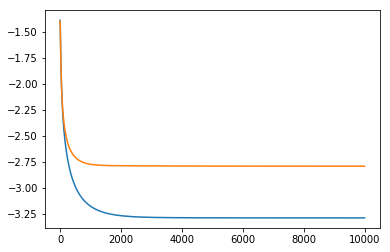

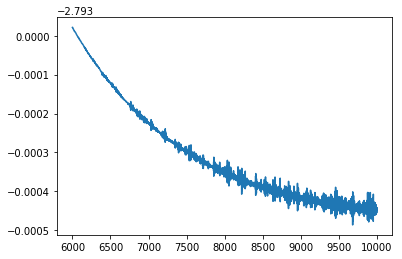

In [546]:
i = range(len(train_loss))
cut = 0
plt.plot(i[cut:], np.log(train_loss[cut:]), i[cut:], np.log(test_loss[cut:]))
fig,ax = plt.subplots()

cut = 6000
plt.plot(i[cut:], np.log(test_loss[cut:]))

In [547]:
np.argmin(test_loss)

9682

reset Linear(in_features=1024, out_features=128, bias=True)
0. train loss: 0.23358099162578583, test loss: 0.21737951040267944
100. train loss: 0.0716606006026268, test loss: 0.09007170796394348
200. train loss: 0.050262272357940674, test loss: 0.07822661101818085
300. train loss: 0.040327757596969604, test loss: 0.07504531741142273
400. train loss: 0.03422330319881439, test loss: 0.07438449561595917


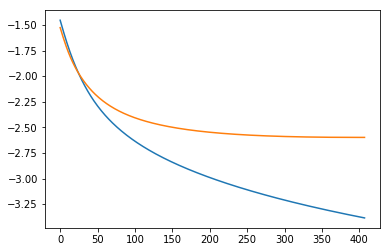

In [23]:
simple_model = simple_model.apply(reset)
optimizer = torch.optim.Adam(simple_model.parameters(), lr=learning_rate, weight_decay = 0.0)

train_loss, test_loss = train(simple_model, optimizer, loss_fn, 
                              X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                             numepochs = np.argmin(test_loss))

i = range(len(train_loss))
cut = 0
plt.plot(i[cut:], np.log(train_loss[cut:]), i[cut:], np.log(test_loss[cut:]))

x
y


([<Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>],
  <matplotlib.axes._subplots.AxesSubplot at 0x1a2c28d550>])

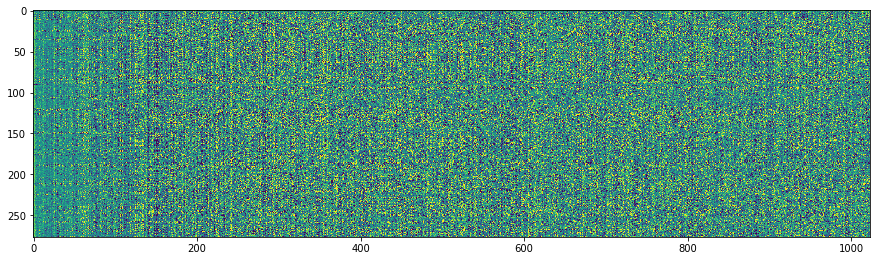

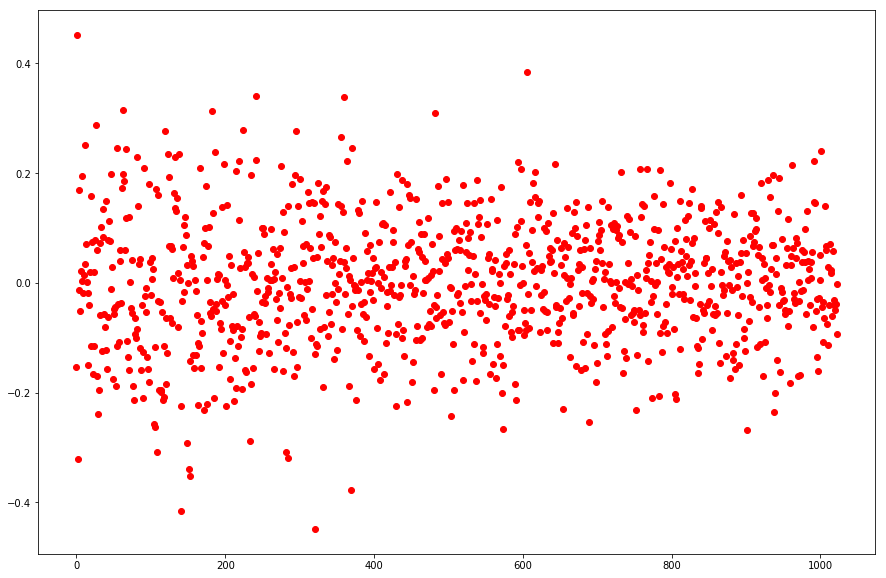

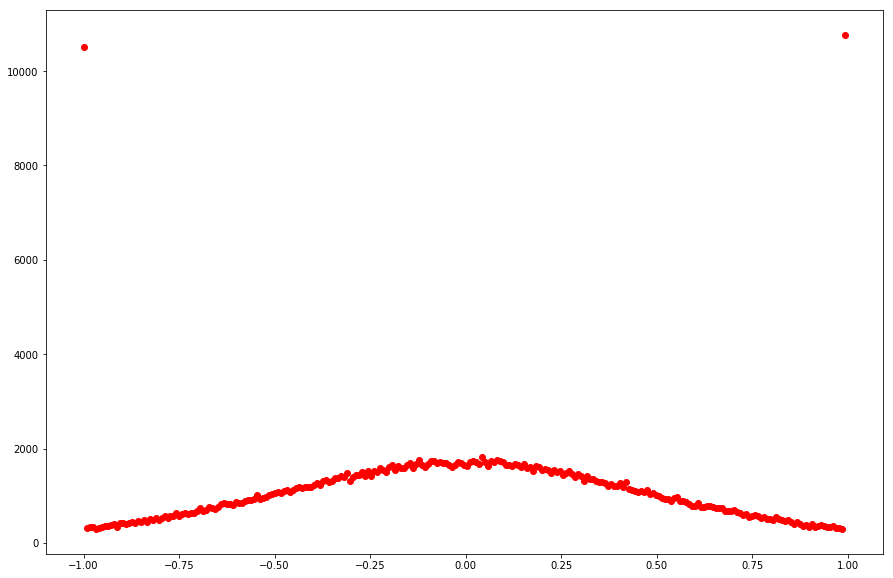

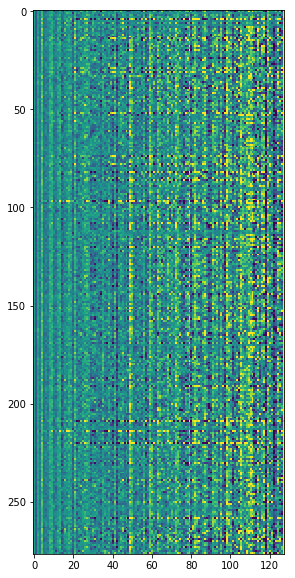

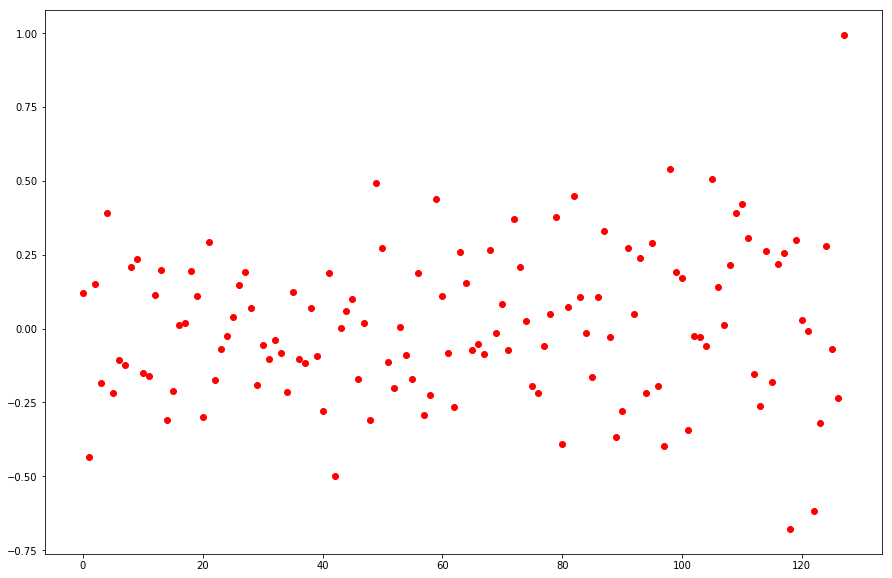

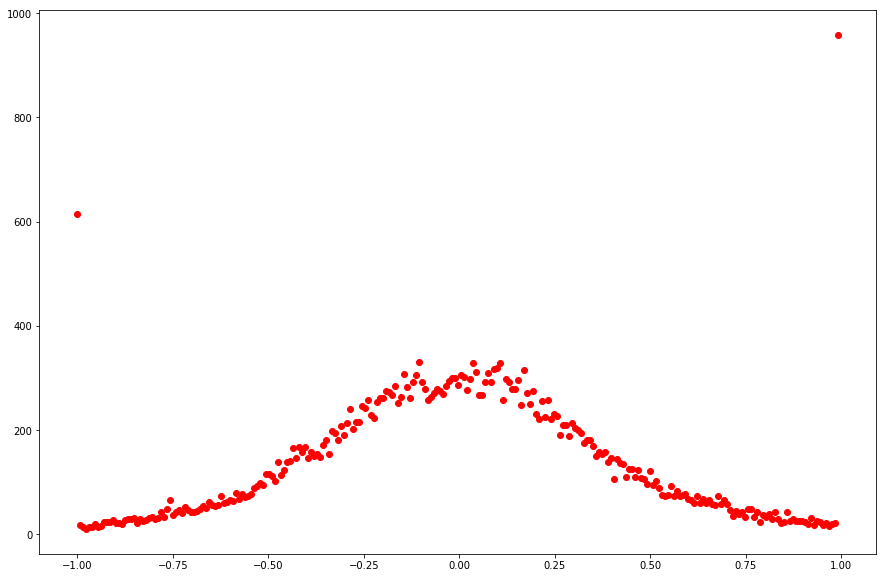

In [463]:
makeplots(X_test, y_test)

In [551]:
y_test_predict_tensor = simple_model(X_test_tensor)
ytp_np = y_test_predict_tensor.detach().numpy()

In [552]:
ytp_np.shape

(277, 128)

In [553]:
ytp_np.min()

-0.9567569

x
y


([<Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>],
  <matplotlib.axes._subplots.AxesSubplot at 0x1a2b8224a8>])

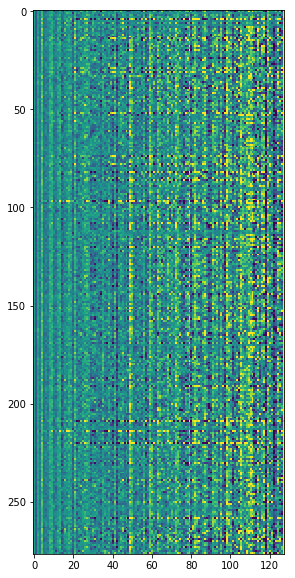

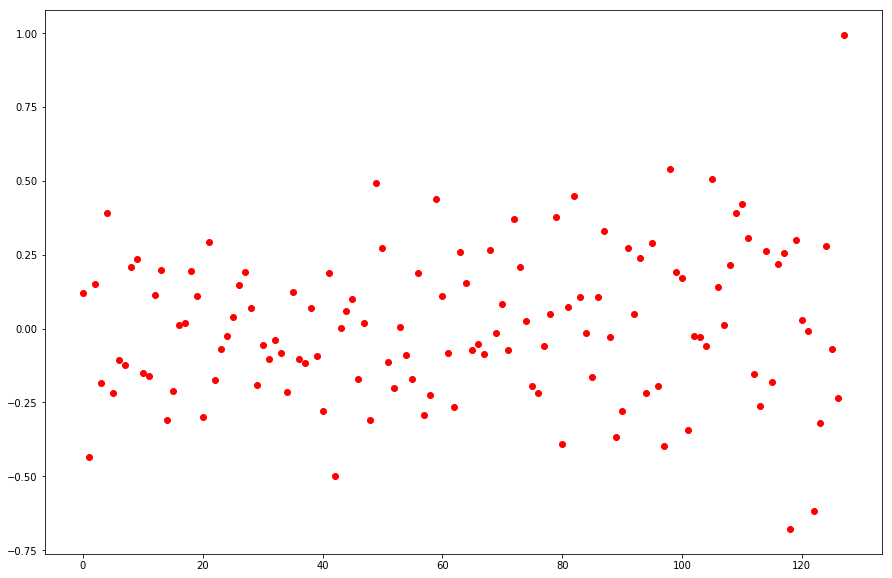

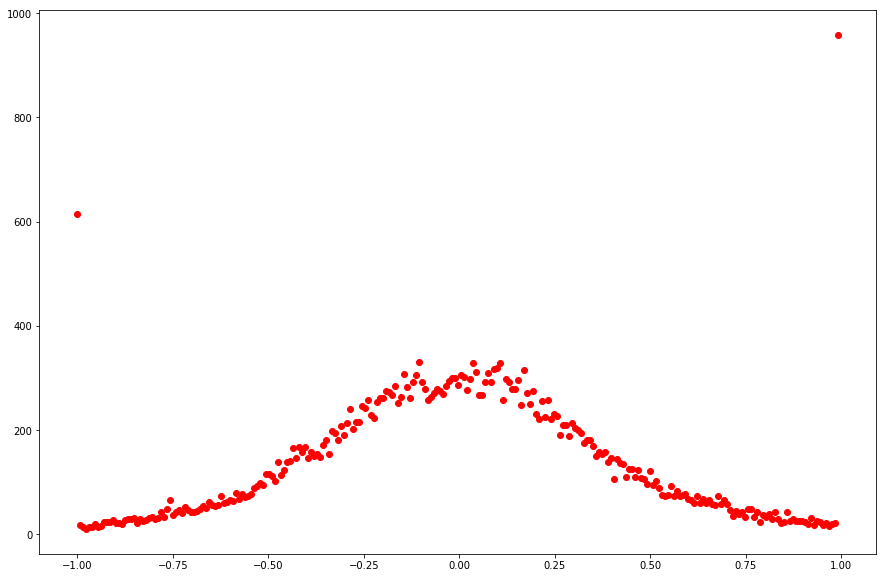

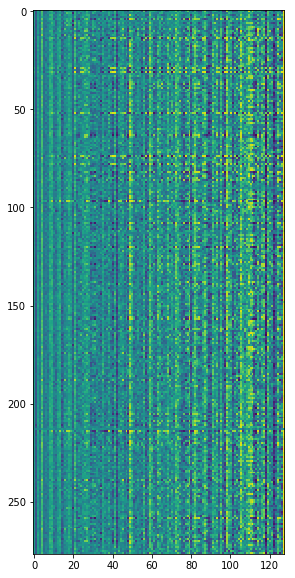

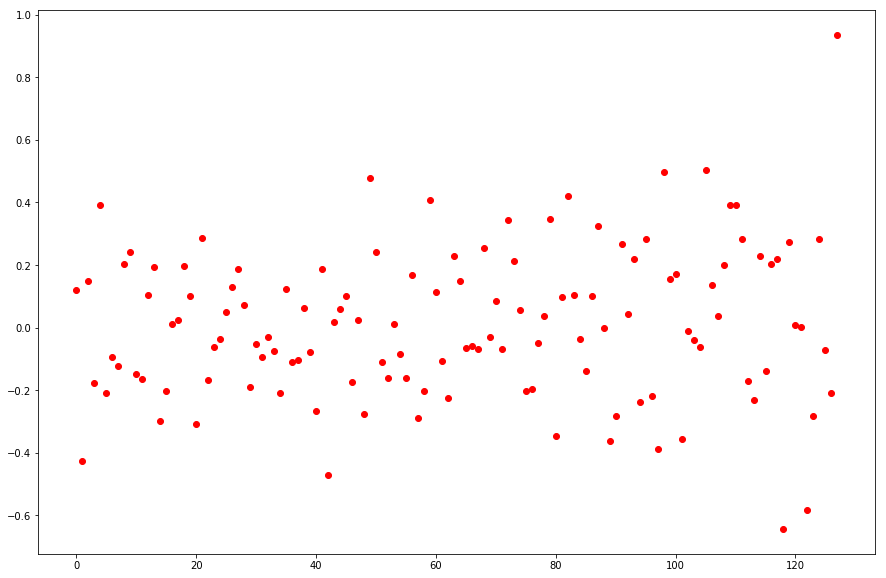

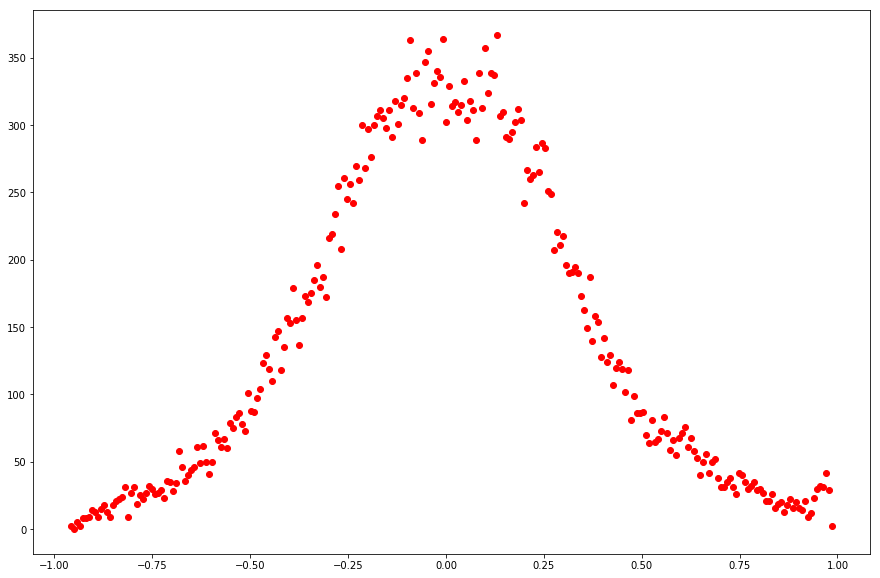

In [554]:
makeplots(y_test, ytp_np)

In [150]:
# print(_unscale(ytp_np).max())
# print(_unscale(y_test).max())
# print(_unscale(ytp_np).min())
# print(_unscale(y_test).min())
# print(_unscale(ytp_np).mean())
# print(_unscale(y_test).mean())

253.59865
255.0
2.6230392
0.0
128.85878
128.75085


In [555]:
residual = y_test - ytp_np

x
y


([<Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>],
  <matplotlib.axes._subplots.AxesSubplot at 0x1a2b7824a8>])

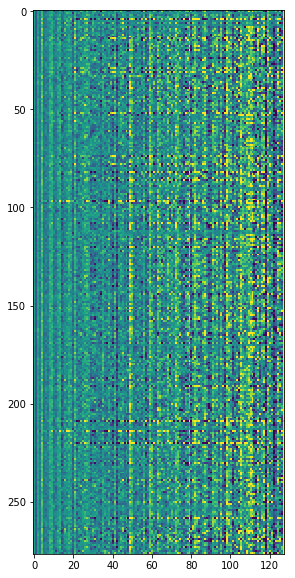

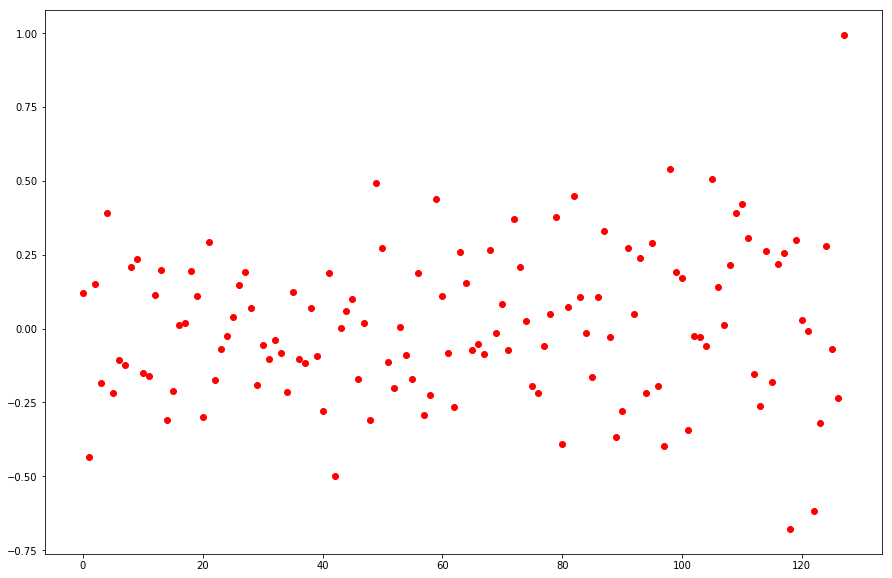

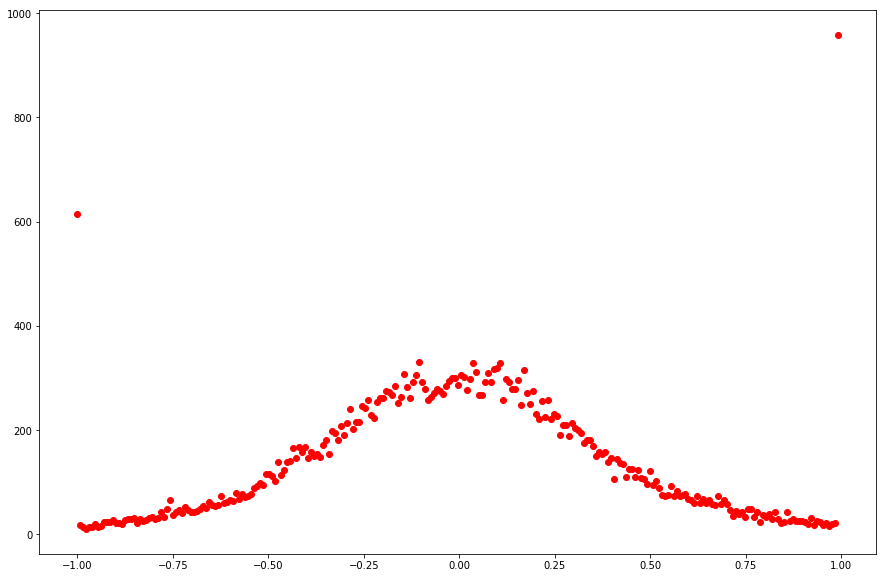

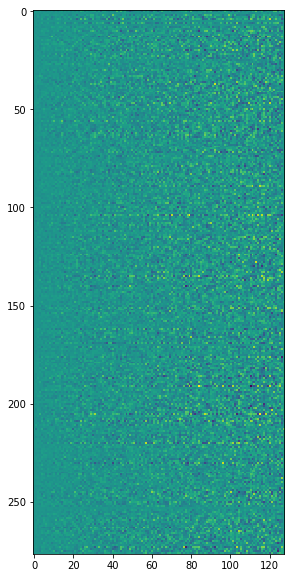

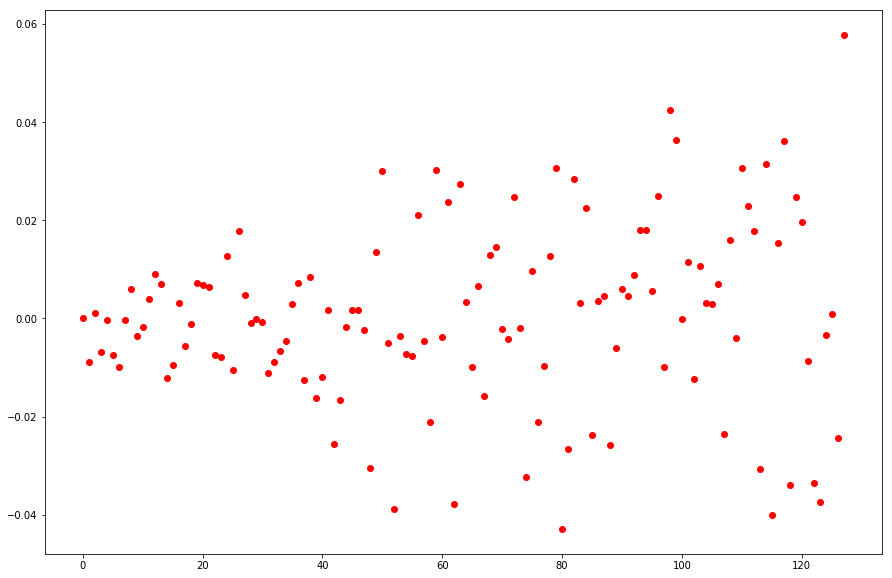

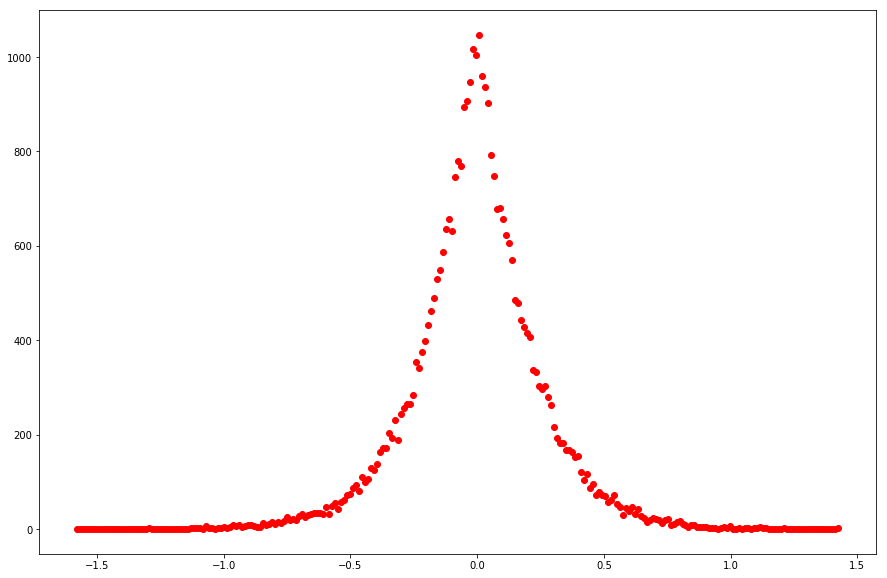

In [556]:
makeplots(y_test, residual)

In [557]:
def describe(data):
    def printstat(stat, value):
        print('{}: {}'.format(stat, value))
    
    printstat('mean', np.mean(data))
    printstat('max', np.max(data))
    printstat('min', np.min(data))
    printstat('std', np.std(data))


print('residual')
describe(residual)
print('y_test')
describe(y_test)
print('y_predict')
describe(ytp_np)


residual
mean: 0.0003860972647089511
max: 1.436706781387329
min: -1.5766940116882324
std: 0.24740755558013916
y_test
mean: 0.012155508622527122
max: 1.0
min: -1.0
std: 0.41509515047073364
y_predict
mean: 0.011769411154091358
max: 0.9941027164459229
min: -0.9567568898200989
std: 0.33433589339256287


## Quick Ad-Hoc Experiments to test L2 regularization

reset Linear(in_features=1024, out_features=512, bias=True)
reset Linear(in_features=512, out_features=256, bias=True)
reset Linear(in_features=256, out_features=128, bias=True)
0. train loss: 0.19470715522766113, test loss: 0.17772817611694336
100. train loss: 0.04495704919099808, test loss: 0.06368114799261093
200. train loss: 0.030845217406749725, test loss: 0.06444471329450607
300. train loss: 0.022476453334093094, test loss: 0.07089822739362717
400. train loss: 0.017055578529834747, test loss: 0.07895971089601517
500. train loss: 0.013313788920640945, test loss: 0.08726087957620621
600. train loss: 0.010626690462231636, test loss: 0.09522899985313416
700. train loss: 0.008645158261060715, test loss: 0.10283786058425903
800. train loss: 0.007153980899602175, test loss: 0.10976330190896988
900. train loss: 0.0060186684131622314, test loss: 0.11602655798196793
137
reset Linear(in_features=1024, out_features=512, bias=True)
reset Linear(in_features=512, out_features=256, bias=True)
re

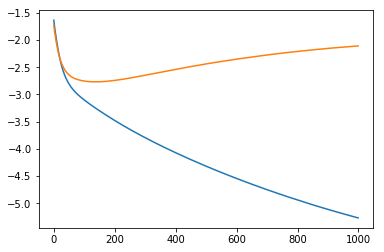

In [88]:
## first pass




choose_model = simple_model
#choose_model = fancy_model


choose_model = choose_model.apply(reset)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-4

optimizer = torch.optim.Adam(choose_model.parameters(), lr=learning_rate, weight_decay = 0.0)

train_loss, test_loss = train(choose_model, optimizer, loss_fn, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

i = range(len(train_loss))
cut = 0
plt.plot(i[cut:], np.log(train_loss[cut:]), i[cut:], np.log(test_loss[cut:]))

## find optimal training stopping point
print(np.argmin(test_loss))

choose_model = choose_model.apply(reset)
optimizer = torch.optim.Adam(choose_model.parameters(), lr=learning_rate, weight_decay = 0.0)

train_loss, test_loss = train(choose_model, optimizer, loss_fn, 
                              X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                             numepochs = np.argmin(test_loss))

y_test_predict_tensor = choose_model(X_test_tensor)
ytp_np = y_test_predict_tensor.detach().numpy()

residual = y_test - ytp_np

print('residual')
describe(residual)
print('y_test')
describe(y_test)
print('y_predict')
describe(ytp_np)


x
y


([<Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>,
  <Figure size 1080x720 with 1 Axes>],
  <matplotlib.axes._subplots.AxesSubplot at 0x1a19fab0b8>])

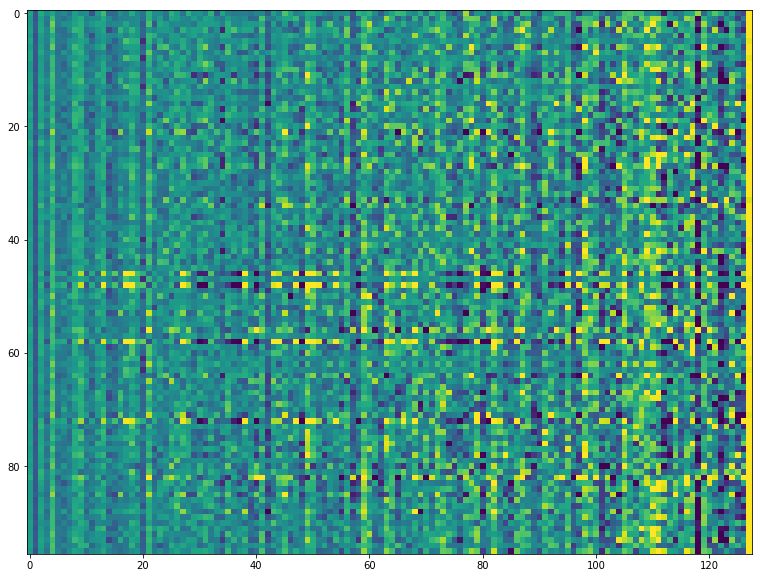

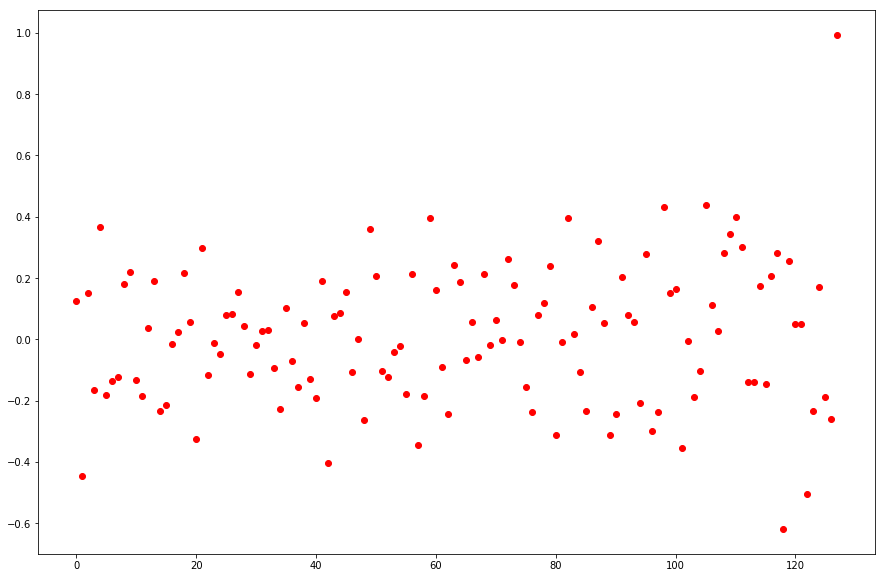

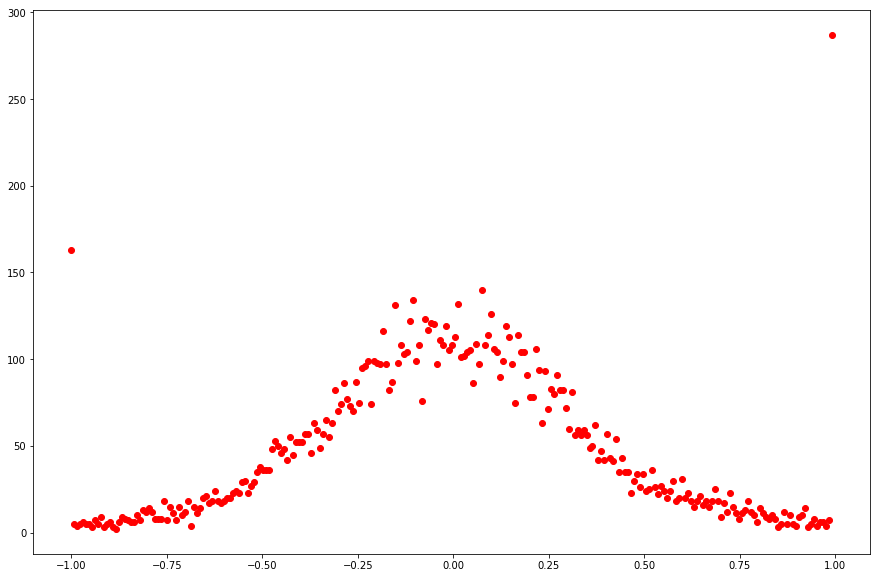

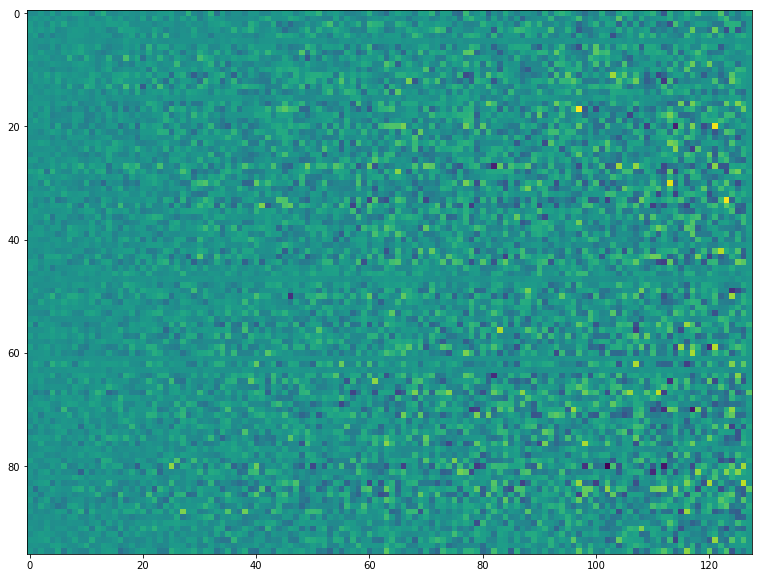

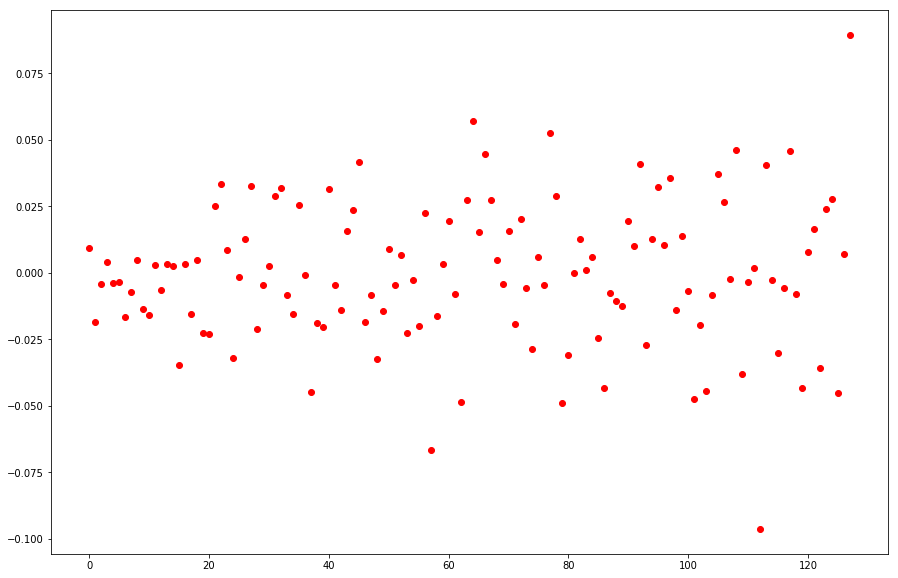

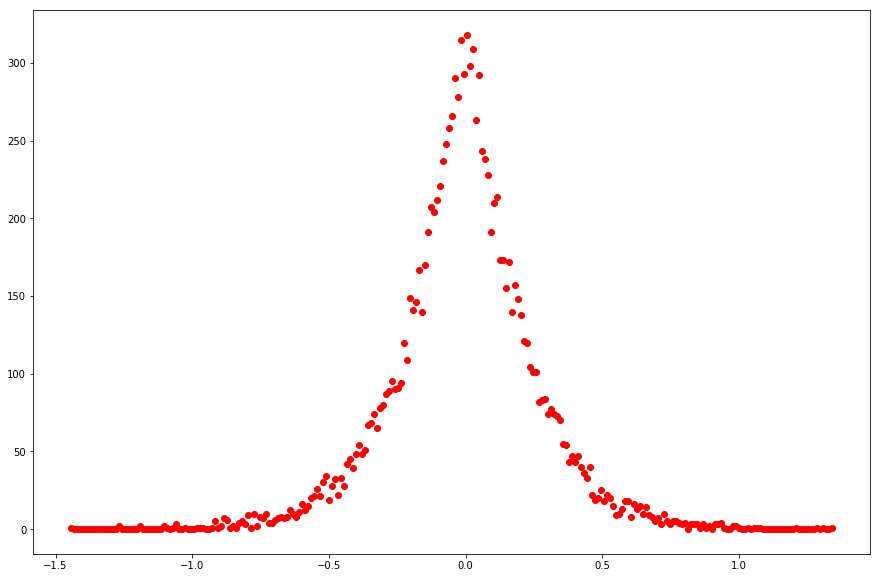

In [89]:
makeplots(y_test, residual)

In [470]:
stl10_train = dset.STL10('.', split='train', download=True)

Files already downloaded and verified


In [471]:
STL_CLASS_PATH = './stl10_binary/class_names.txt'
def get_stl_class_list(path):
    with open(path, 'r') as f:
        labels = f.readlines()
        return list(map(lambda x:x.strip('\n'), labels))

stl_label_names = get_stl_class_list(STL_CLASS_PATH)

In [472]:
stl_label_names

['airplane',
 'bird',
 'car',
 'cat',
 'deer',
 'dog',
 'horse',
 'monkey',
 'ship',
 'truck']

In [473]:
STL_LABEL_PATH = './stl10_binary/train_y.bin'
def read_stl_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

In [ ]:
test_animals = ['horse', 'dog', 'cat']

animal_indexes = {}
num_samples = 500

for animal in test_animals:
    i = 0
    index_list = []
    while len(index_list) < num_samples:
        ex = stl10_train[i]
        if ex[1] == stl_label_names.index(animal):
            index_list.append(i)

        i += 1
    animal_indexes[animal] = index_list

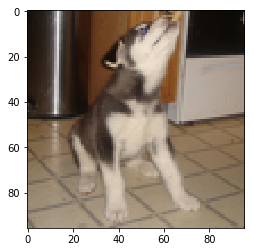

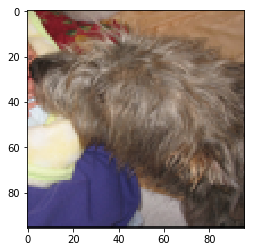

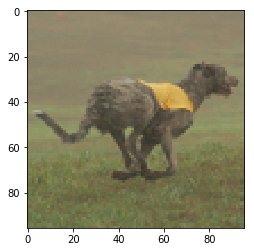

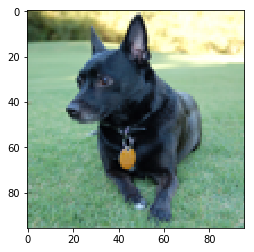

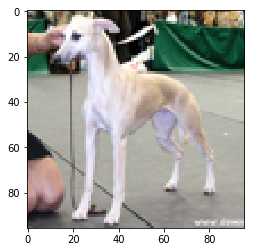

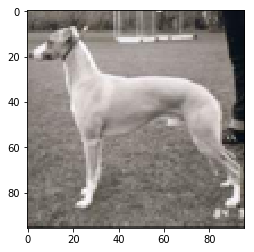

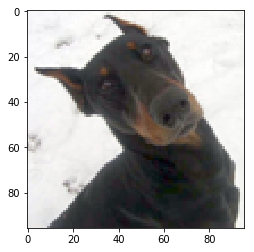

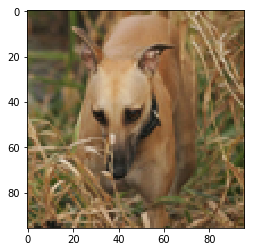

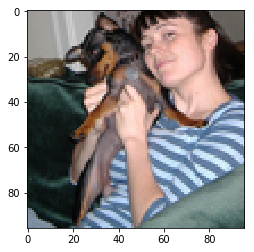

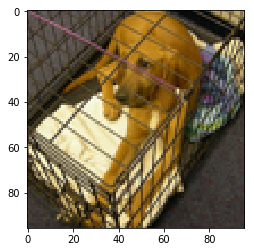

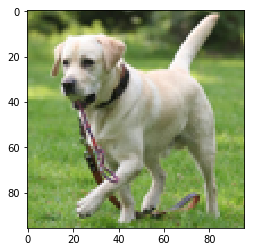

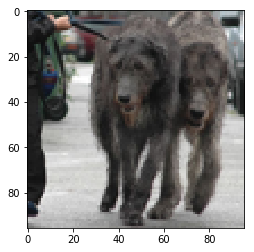

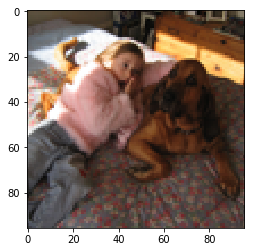

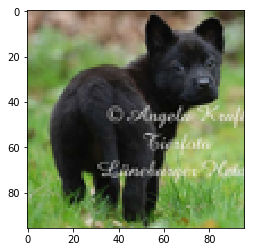

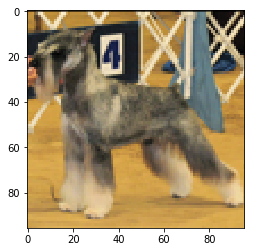

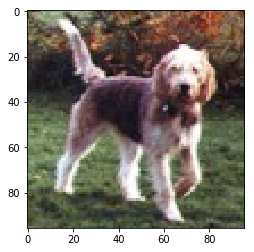

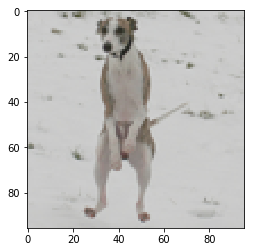

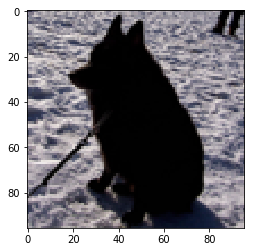

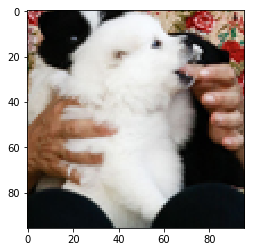

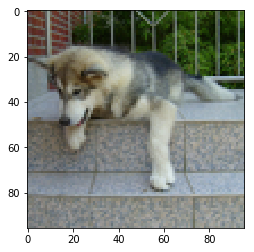

In [476]:
_thisanimal = 'dog'

for i in range(50,70):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(stl10_train[animal_indexes[_thisanimal][i]][0])
    del fig
    del ax

In [478]:
soundeffectfiles = glob.glob('../data/soundeffectfiles/features/*.json')
len(soundeffectfiles)

72

In [479]:
sfbasename = [os.path.basename(x) for x in soundeffectfiles]
print('\n'.join(sfbasename))

Wolf_Rallying.wav.json
horse_trotting_rough_track_stop_depart.wav.json
car_two_honks.wav.json
polar_bear.wav.json
Lanna-pig.wav.json
Brown_Bear.wav.json
mitch-pigeon.wav.json
rooster.wav.json
elephant9.wav.json
rachel-songbird.wav.json
church_bells.wav.json
tiger_copy.wav.json
frog.wav.json
tiger_copy_2.wav.json
Tiger7.wav.json
Tiger6.wav.json
mad_polar_bear.wav.json
lion4.wav.json
sheep.wav.json
lanna-dolphin.wav.json
carina-rooster.wav.json
horse_gallops_past_on_field.wav.json
siamese_cat.wav.json
pig1.wav.json
lion_44.wav.json
polar_bear_2.wav.json
chicks.wav.json
dog_pup2.wav.json
cat1.wav.json
donkey.wav.json
horse_trotting_rough_track.wav.json
tiger.wav.json
elephant.wav.json
Mitch-cougar.wav.json
geiger_counter.wav.json
Cat_Meow-SoundBible.com-1977450526.wav.json
tom_cat_meow.wav.json
one_horse_walking_tarmac.wav.json
chicken_clucking.wav.json
rachel-pig.wav.json
Tiger4.wav.json
dog_barking.wav.json
fake_rocket_ship_takeoff.wav.json
Tiger2(1).wav.json
Lanna-cat.wav.json
elephant

In [496]:
_SOUNDFILE_FEATURES = {}
for sf in soundeffectfiles:
    sfdict = json.load(open(sf,'r'))
    _SOUNDFILE_FEATURES[sf] = sfdict

In [498]:

def _calcCosSim(audio_features):
    sf_similarities = []
    for k,v in _SOUNDFILE_FEATURES.items():
        mean_audio = np.array(v['mean_audio']).reshape(1,-1)
        cossim = cosine_similarity(audio_features, mean_audio)
        sf_similarities.append((v['filename'], cossim[0][0], k))
    return sf_similarities

In [558]:
extractor = feature_extractor.YouTube8MFeatureExtractor()
choose_model = simple_model

choose_model = choose_model.eval()


In [499]:
def plot_image(imgfile):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(imgfile)
    del fig
    del ax
    
def predict_audio(imgfile):
    feat = extractor.extract_rgb_frame_features(np.array(imgfile))
    feat = clip_n_scale(feat, -video_range, video_range)
    feat = feat[np.newaxis,:]
    #describe(feat)
    audio_pred = choose_model(torch.from_numpy(feat)).detach().numpy()
    sfsims = _calcCosSim( audio_pred )
    sfsims.sort(key = lambda x:x[1], reverse=True)
    sfsims = list(sfsims)
    
    return sfsims

def numlabel_match(soundfilelist, imglabel):
    return [x[0].find(imglabel) != -1 for x in soundfilelist]


In [605]:

def getBaseStats(sflist, label):
    sfbaseline = [os.path.basename(x) for x in sflist]
    decksize = len(sfbaseline)
    numlabels = np.sum([x.find(label) != -1 for x in sfbaseline])
        
    return decksize, numlabels

def expectedNumByHand(sflist, label, size):
    '''
    computes the expected number of sound files in a random draw without replacement
    
    sflist - list of sound files
    label - label to match to name of soundfiles
    size - size of the draw
    '''
    
    decksize, numlabels = getBaseStats(sflist, label)
    remainder = decksize - numlabels
    
    expectation_value = 0
    for i in range(1, size+1):
        expectation_value += i * scipy.special.comb(remainder,size-i, exact=True) * scipy.special.comb(numlabels,i, exact=True)

    return expectation_value / scipy.special.comb(decksize,size, exact=True)

def getProbs(sflist, label, size):
    
    decksize, numlabels = getBaseStats(sflist, label)
    
    hyperfun = hypergeom(decksize, numlabels, size)
    return hyperfun.pmf(np.arange(0,size+1))
    

def expectedNum(sflist, label, size):
    '''
    computes the expected number of sound files in a random draw without replacement
    
    sflist - list of sound files
    label - label to match to name of soundfiles
    size - size of the draw
    '''
    
    return np.sum([(i)*p for i,p in enumerate(getProbs(sflist, label, size))]) 

def expectedNumSq(sflist, label, size):
    '''
    computes the expected number^2 of sound files in a random draw without replacement
    
    can use to compute the variance = expectedNumSq - expectedNum^2
    sflist - list of sound files
    label - label to match to name of soundfiles
    size - size of the draw
    '''
    
    return np.sum([(i)**2*p for i,p in enumerate(getProbs(sflist, label, size))]) 


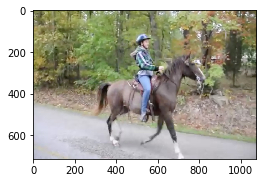

In [634]:
## test one....


#imgfile = stl10_train[animal_indexes['horse'][0]][0]
imgfile = Image.open('/Users/adam/Desktop/horse.jpg')

sfsims = predict_audio(imgfile)
plot_image(imgfile)


In [635]:
matches = numlabel_match(sfsims,'horse')


In [636]:
matches

[True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [528]:
np.sum(np.array(matches)[:5])

0

In [529]:
len(sfsims)

72

In [530]:
test_animals

['horse', 'dog', 'cat']

In [587]:
results = []
topN = 5
top_N_results = {}
for animal_label in test_animals:
    print(animal_label)
    num_top_N = []
    for animal_index in animal_indexes[animal_label]:
        sfsims = predict_audio(stl10_train[animal_index][0])
        matches = numlabel_match(sfsims,animal_label)
        num_top_N.append(np.sum(np.array(matches)[:topN]))
        
    expValue = expectedNum(soundeffectfiles, animal_label, topN)
    expValueSq = expectedNumSq(soundeffectfiles, animal_label, topN)
    
    expStdDev = np.sqrt(expValueSq - expValue**2)
    top_N_results[animal_label] = num_top_N
    results.append([animal_label, np.mean(num_top_N), 
                    np.sqrt( np.std(num_top_N) )/np.sqrt(len(num_top_N)), 
                    np.sqrt( np.mean(num_top_N) )/np.sqrt(len(num_top_N)), 
                    expValue, expStdDev ])

horse
dog
cat


(array([44., 14., 22.,  7., 13.,  0.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

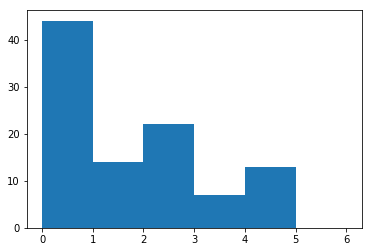

In [628]:
plt.hist(top_N_results['horse'],bins=[0,1,2,3,4,5,6])

In [617]:
probs = getProbs(soundeffectfiles, 'lanna', 5)
print(probs)

[0.86502347 0.13106416 0.00391236 0.         0.         0.        ]


In [600]:
probs = getProbs(soundeffectfiles, 'horse', 5)
print(probs)

[3.09066676e-01 4.90582026e-02 3.06613766e-03 7.07570230e-05
 4.28830442e-07]


In [615]:
print('the std of the expected number by random are poisson')
for rr in results:
    print('{}: {:.2f} +- {:.2f} (sqrt(mean): {:.2f})  --> {:.2f} +- {:.2f}'.format(*rr))

the std of the expected number by random are poisson
horse: 1.31 +- 0.12 (sqrt(mean): 0.11)  --> 0.42 +- 0.60
dog: 1.06 +- 0.09 (sqrt(mean): 0.10)  --> 0.28 +- 0.50
cat: 0.80 +- 0.08 (sqrt(mean): 0.09)  --> 0.49 +- 0.64


/Users/adam/anaconda3/envs/soundeffects/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


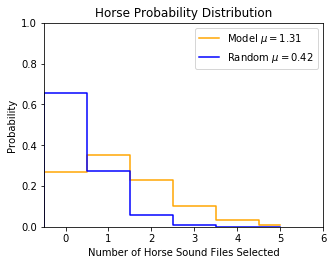

In [626]:

mu_values = [1.31, 0.42]

fig, ax = plt.subplots(figsize=(1*5, 1*3.75))

x = np.arange(-1, 6)

dist = poisson(mu_values[0])

plt.plot(x, dist.pmf(x), ls='-', color='orange',
     label=r'Model $\mu=1.31$', linestyle='steps-mid')
   
dist = poisson(mu_values[1])
plt.plot(x, dist.pmf(x), ls=':', color='blue',
     label=r'Random $\mu=0.42$', linestyle='steps-mid')

plt.xlim(-0.5, 6)
plt.ylim(0, 1)

plt.xlabel('Number of Horse Sound Files Selected')
plt.ylabel(r'Probability')
plt.title('Horse Probability Distribution')

plt.legend()


/Users/adam/anaconda3/envs/soundeffects/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


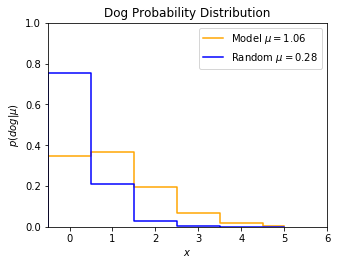

In [586]:
mu_values = [1.06, 0.28]

fig, ax = plt.subplots(figsize=(5, 3.75))

x = np.arange(-1, 6)

dist = poisson(mu_values[0])

plt.plot(x, dist.pmf(x), ls='-', color='orange',
     label=r'Model $\mu=1.06$', linestyle='steps-mid')
   
dist = poisson(mu_values[1])
plt.plot(x, dist.pmf(x), ls=':', color='blue',
     label=r'Random $\mu=0.28$', linestyle='steps-mid')

plt.xlim(-0.5, 6)
plt.ylim(0, 1)

plt.xlabel('$x$')
plt.ylabel(r'$p(dog |\mu)$')
plt.title('Dog Probability Distribution')

plt.legend()



/Users/adam/anaconda3/envs/soundeffects/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2446: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


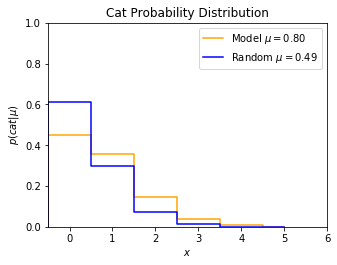

In [585]:
mu_values = [0.80, 0.49]

fig, ax = plt.subplots(figsize=(5, 3.75))

x = np.arange(-1, 6)

dist = poisson(mu_values[0])

plt.plot(x, dist.pmf(x), ls='-', color='orange',
     label=r'Model $\mu=0.80$', linestyle='steps-mid')
   
dist = poisson(mu_values[1])
plt.plot(x, dist.pmf(x), ls=':', color='blue',
     label=r'Random $\mu=0.49$', linestyle='steps-mid')

plt.xlim(-0.5, 6)
plt.ylim(0, 1)

plt.xlabel('$x$')
plt.ylabel(r'$p(cat |\mu)$')
plt.title('Cat Probability Distribution')

plt.legend()

In [588]:
torch.save(choose_model.state_dict(), 'simple_model_jun21.pt')

